In [3]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:.2f}".format
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk')
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score
from causalinference import CausalModel

In [4]:
df = sns.load_dataset('titanic')
df['is_pclass3'] = df['pclass']==3
df['is_female'] = df['sex']=='female'
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,is_pclass3,is_female
0,0,3,male,22.00,1,0,7.25,S,Third,man,True,NaN,Southampton,no,False,True,False
1,1,1,female,38.00,1,0,71.28,C,First,woman,False,C,Cherbourg,yes,False,False,True
2,1,3,female,26.00,0,0,7.92,S,Third,woman,False,NaN,Southampton,yes,True,True,True
3,1,1,female,35.00,1,0,53.10,S,First,woman,False,C,Southampton,yes,False,False,True
4,0,3,male,35.00,0,0,8.05,S,Third,man,True,NaN,Southampton,no,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.00,0,0,13.00,S,Second,man,True,NaN,Southampton,no,True,False,False
887,1,1,female,19.00,0,0,30.00,S,First,woman,False,B,Southampton,yes,True,False,True
888,0,3,female,NaN,1,2,23.45,S,Third,woman,False,NaN,Southampton,no,False,True,True
889,1,1,male,26.00,0,0,30.00,C,First,man,True,C,Cherbourg,yes,True,False,False


In [5]:
df = df.filter(['survived', 'is_pclass3', 'is_female', 'age'])\
       .dropna().reset_index(drop=True)
df

,survived,is_pclass3,is_female,age
0,0,True,False,22.00
1,1,False,True,38.00
2,1,True,True,26.00
3,1,False,True,35.00
4,0,True,False,35.00
...,...,...,...,...
709,0,True,True,39.00
710,0,False,False,27.00
711,1,False,True,19.00
712,1,False,False,26.00


In [6]:
TREATMENT = 'is_pclass3'
OUTCOME = 'survived'
df.groupby(TREATMENT)[OUTCOME].describe()

,count,mean,std,min,25%,50%,75%,max
is_pclass3,,,,,,,,
False,359.00,0.57,0.50,0.00,0.00,1.00,1.00,1.00
True,355.00,0.24,0.43,0.00,0.00,0.00,0.00,1.00


/opt/anaconda3/envs/causalml-tf-py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  import sys
/opt/anaconda3/envs/causalml-tf-py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  if __name__ == "__main__":


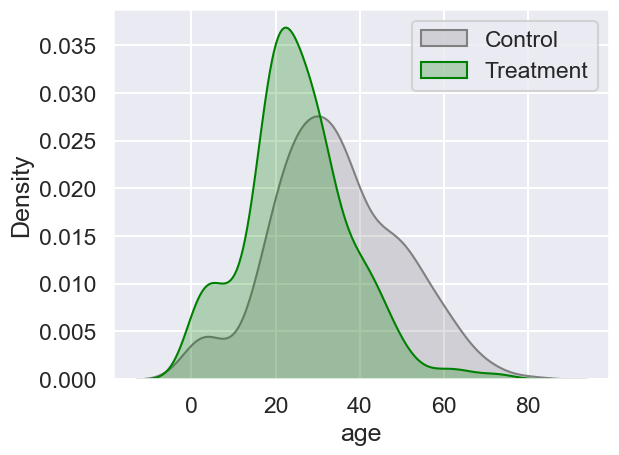

In [7]:
#三等舱乘客（治疗组）的存活率为 24%，而其他舱位乘客（对照组）的存活率为 57%。现在让我们检查治疗组的混杂因素的分布：
#与对照组相比，实验组有更多年轻乘客
C_COLOUR = 'grey'
T_COLOUR = 'green'
C_LABEL = 'Control'
T_LABEL = 'Treatment'
sns.kdeplot(data=df[~df[TREATMENT]], x='age', shade=True, 
            color=C_COLOUR, label=C_LABEL)
sns.kdeplot(data=df[df[TREATMENT]], x='age', shade=True, 
            color=T_COLOUR, label=T_LABEL)
plt.legend()

Text(0, 0.5, 'Percentage')

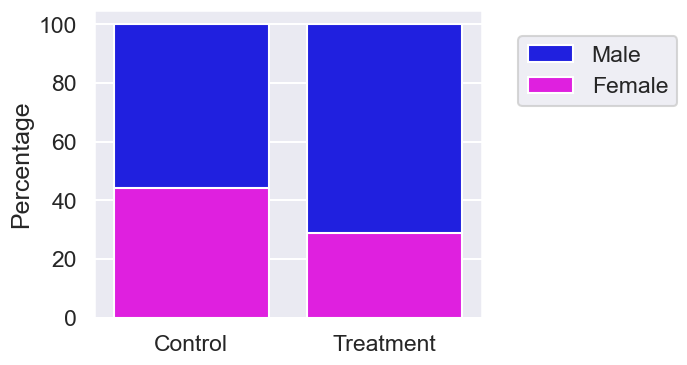

In [8]:
#性别分布
#实验组男性更多
F_COLOUR = 'magenta'
M_COLOUR = 'blue'
F_LABEL = 'Female'
M_LABEL = 'Male'
gender = 100 * pd.crosstab(df[TREATMENT].replace({True: T_LABEL, 
                                                  False: C_LABEL}), 
                           df['is_female'].replace({True: 'Female',
                                                    False: 'Male'}), 
                           normalize='index')
gender['All'] = 100
plt.figure(figsize=(5, 4))
sns.barplot(data=gender, x=gender.index.astype(str),  y="All", 
            color=M_COLOUR, label=M_LABEL)
sns.barplot(data=gender, x=gender.index.astype(str),  y='Female', 
            color=F_COLOUR, label=F_LABEL)
plt.legend(loc='center', bbox_to_anchor=(1.3, 0.8))
plt.xlabel('')
plt.ylabel('Percentage')

In [11]:
#治疗组也有更多的男性。由于两组之间的混杂因素并不平衡，因此说生存率的差异是由于现阶段的治疗所致是天真的。现在，让我们学习如何使各组更具可比性。
#估计倾向得分

# Build a descriptive model
t = df[TREATMENT]
X = pd.get_dummies(df.drop(columns=[OUTCOME, TREATMENT]))
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_classifier', LogisticRegression())
])
pipe.fit(X, t)
# Predict
threshold = 0.5
df['proba'] = pipe.predict_proba(X)[:,1]
df['logit'] = df['proba'].apply(lambda p: np.log(p/(1-p)))
df['pred'] = np.where(df['proba']>=threshold, 1, 0)
df.head()

,survived,is_pclass3,is_female,age,proba,logit,pred
0,0,True,False,22.00,0.67,0.70,1
1,1,False,True,38.00,0.26,-1.02,0
2,1,True,True,26.00,0.40,-0.40,0
3,1,False,True,35.00,0.30,-0.87,0
4,0,True,False,35.00,0.51,0.03,1


In [12]:
# 倾向得分告诉我们，在考虑混淆因子的情况下，个体接受treatment的概率
print(f"Accuracy: {np.mean(df[TREATMENT]==df['pred']):.4f},\
 ROC AUC: {roc_auc_score(df[TREATMENT], df['proba']):.4f},\
 F1-score: {f1_score(df[TREATMENT], df['pred']):.4f}")
# Visualise confusion matrix
pd.crosstab(df[TREATMENT], df['pred']).rename(columns={0: False, 
                                                       1:True})

Accuracy: 0.6695, ROC AUC: 0.7197, F1-score: 0.6776


pred,False,True
is_pclass3,,
False,230,129
True,107,248


/opt/anaconda3/envs/causalml-tf-py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  after removing the cwd from sys.path.
/opt/anaconda3/envs/causalml-tf-py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  
/opt/anaconda3/envs/causalml-tf-py37/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/envs/causalml-tf-py37/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; settin

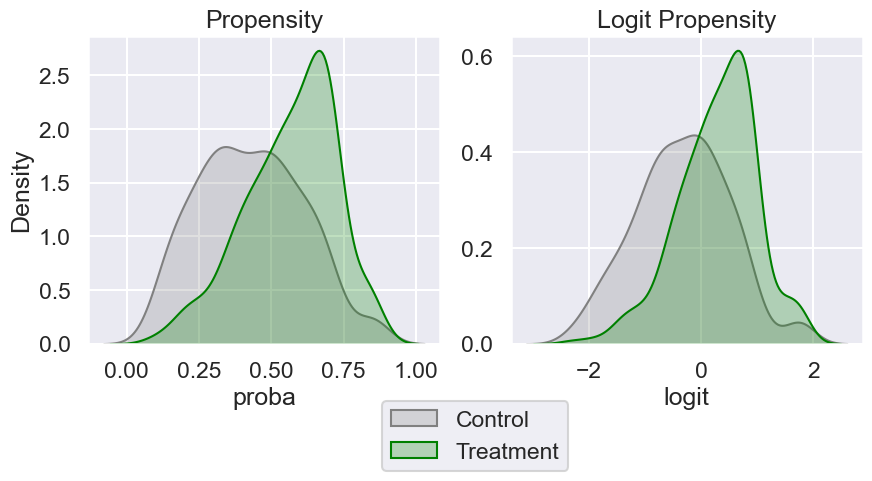

In [13]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
# Visualise propensity
sns.kdeplot(data=df[~df[TREATMENT]], x='proba', shade=True, 
            color=C_COLOUR, label=C_LABEL, ax=ax[0])
sns.kdeplot(data=df[df[TREATMENT]], x='proba', shade=True, 
            color=T_COLOUR, label=T_LABEL, ax=ax[0])
ax[0].set_title('Propensity')
ax[0].legend(loc='center', bbox_to_anchor=(1.1, -0.3))
# Visualise logit propensity
sns.kdeplot(data=df[~df[TREATMENT]], x='logit', shade=True, 
            color=C_COLOUR, label=C_LABEL, ax=ax[1])
sns.kdeplot(data=df[df[TREATMENT]], x='logit', shade=True, 
            color=T_COLOUR, label=T_LABEL, ax=ax[1])
ax[1].set_title('Logit Propensity')
ax[1].set_ylabel("");

In [14]:
# 匹配记录
#我们将把最相似的控制记录与治疗组中的乘客进行匹配。在一个维度（倾向得分）中查找相似记录比在多个维度（混杂因素）中查找相似记录要容易得多。
#这可能会让您想起降维方法。倾向得分是一个平衡得分。这意味着，如果我们根据倾向得分匹配记录，则匹配记录之间的混杂因素的分布可能会相似。

# Sort by 'logit' so it's quicker to find match
df.sort_values('logit', inplace=True)
n = len(df)-1
for i, (ind, row) in enumerate(df.iterrows()): 
    # Match the most similar untreated record to each treated record
    if row[TREATMENT]:
        # Find the closest untreated match among records sorted 
        # higher. 'equal_or_above would' be more accurate but 
        # used 'above' for brevity        
        if i<n:
            above = df.iloc[i:]
            control_above = above[~above[TREATMENT]]
            match_above = control_above.iloc[0]
            distance_above = match_above['logit'] - row['logit']
            df.loc[ind, 'match'] = match_above.name
            df.loc[ind, 'distance'] = distance_above
        
        # Find the closest untreated match among records sorted 
        # lower. 'equal_or_below' would be more accurate but 
        # used 'below' for brevity  
        if i>0:
            below = df.iloc[:i-1]
            control_below = below[~below[TREATMENT]]
            match_below = control_below.iloc[-1]
            distance_below = match_below['logit'] - row['logit']
            if i==n:
                df.loc[ind, 'match'] = match_below.name
                df.loc[ind, 'distance'] = distance_below
            
            # Only overwrite if match_below is closer than match_above
            elif distance_below<distance_above:
                df.loc[ind, 'match'] = match_below.name
                df.loc[ind, 'distance'] = distance_below
df[df[TREATMENT]]

,survived,is_pclass3,is_female,age,proba,logit,pred,match,distance
385,1,True,True,63.00,0.09,-2.33,0,221.00,0.00
679,0,True,False,74.00,0.12,-2.01,0,156.00,-0.06
91,0,True,False,70.50,0.14,-1.82,0,74.00,-0.03
586,0,True,True,48.00,0.18,-1.55,0,25.00,-0.04
225,0,True,False,65.00,0.18,-1.54,0,601.00,-0.01
...,...,...,...,...,...,...,...,...,...
6,0,True,False,2.00,0.85,1.75,1,329.00,-0.05
132,0,True,False,1.00,0.86,1.80,1,329.00,-0.10
628,1,True,False,1.00,0.86,1.80,1,273.00,-0.05
309,0,True,False,1.00,0.86,1.80,1,273.00,-0.05


In [15]:
indices = df[df['match'].notna()].index.\
          append(pd.Index(df.loc[df['match'].notna(), 'match']))
matched_df = df.loc[indices].reset_index(drop=True)
matched_df

,survived,is_pclass3,is_female,age,proba,logit,pred,match,distance
0,1,True,True,63.00,0.09,-2.33,0,221.00,0.00
1,0,True,False,74.00,0.12,-2.01,0,156.00,-0.06
2,0,True,False,70.50,0.14,-1.82,0,74.00,-0.03
3,0,True,True,48.00,0.18,-1.55,0,25.00,-0.04
4,0,True,False,65.00,0.18,-1.54,0,601.00,-0.01
...,...,...,...,...,...,...,...,...,...
705,1,False,False,3.00,0.84,1.69,1,NaN,NaN
706,1,False,False,3.00,0.84,1.69,1,NaN,NaN
707,1,False,False,2.00,0.85,1.75,1,NaN,NaN
708,1,False,False,2.00,0.85,1.75,1,NaN,NaN


In [16]:
## 重新评估匹配后的质量
COLUMNS = ['age', 'is_female', OUTCOME]
matches = pd.merge(df.loc[df[TREATMENT], COLUMNS+['match']], 
                   df[COLUMNS], left_on='match', 
                   right_index=True, 
                   how='left', suffixes=('_t', '_c'))
matches

,age_t,is_female_t,survived_t,match,age_c,is_female_c,survived_c
385,63.00,True,1,221.00,63.00,True,1
679,74.00,False,0,156.00,58.00,True,1
91,70.50,False,0,74.00,71.00,False,0
586,48.00,True,0,25.00,66.00,False,0
225,65.00,False,0,601.00,48.00,True,1
...,...,...,...,...,...,...,...
6,2.00,False,0,329.00,3.00,False,1
132,1.00,False,0,329.00,3.00,False,1
628,1.00,False,1,273.00,2.00,False,1
309,1.00,False,0,273.00,2.00,False,1


In [17]:
for var in ['logit', 'age']:
    print(f"{var} | Before matching")
    display(df.groupby(TREATMENT)[var].describe())
    print(f"{var} | After matching")
    display(matched_df.groupby(TREATMENT)[var].describe())

logit | Before matching


,count,mean,std,min,25%,50%,75%,max
is_pclass3,,,,,,,,
False,359.00,-0.33,0.84,-2.33,-0.87,-0.29,0.24,1.82
True,355.00,0.28,0.71,-2.33,-0.18,0.38,0.76,1.83


logit | After matching


,count,mean,std,min,25%,50%,75%,max
is_pclass3,,,,,,,,
False,355.00,0.26,0.70,-2.33,-0.18,0.34,0.76,1.81
True,355.00,0.28,0.71,-2.33,-0.18,0.38,0.76,1.83


age | Before matching


,count,mean,std,min,25%,50%,75%,max
is_pclass3,,,,,,,,
False,359.00,34.21,15.00,0.67,24.00,33.00,45.00,80.00
True,355.00,25.14,12.50,0.42,18.00,24.00,32.00,74.00


age | After matching


,count,mean,std,min,25%,50%,75%,max
is_pclass3,,,,,,,,
False,355.00,25.06,13.96,0.83,17.00,25.00,32.25,71.00
True,355.00,25.14,12.50,0.42,18.00,24.00,32.00,74.00


/opt/anaconda3/envs/causalml-tf-py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  """
/opt/anaconda3/envs/causalml-tf-py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  import sys
/opt/anaconda3/envs/causalml-tf-py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  if sys.path[0] == "":
/opt/anaconda3/envs/causalml-tf-py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.

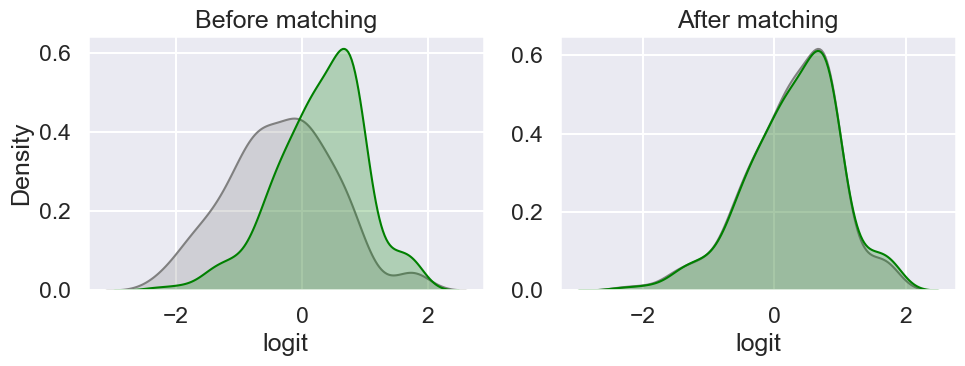

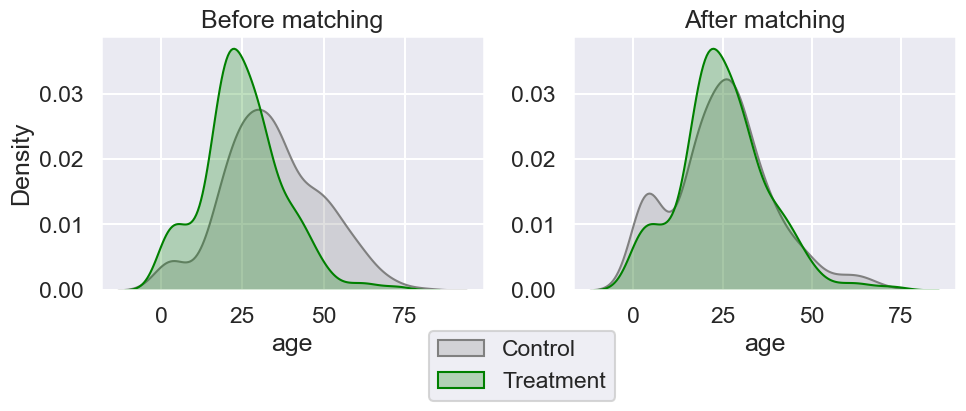

In [18]:
for var in ['logit', 'age']:
    fig, ax = plt.subplots(1,2,figsize=(10,4))
    # Visualise original distribution
    sns.kdeplot(data=df[~df[TREATMENT]], x=var, shade=True, 
                color=C_COLOUR, label=C_LABEL, ax=ax[0])
    sns.kdeplot(data=df[df[TREATMENT]], x=var, shade=True, 
                color=T_COLOUR, label=T_LABEL, ax=ax[0])
    ax[0].set_title('Before matching')
    
    # Visualise new distribution
    sns.kdeplot(data=matched_df[~matched_df[TREATMENT]], x=var, 
                shade=True, color=C_COLOUR, label=C_LABEL, ax=ax[1])
    sns.kdeplot(data=matched_df[matched_df[TREATMENT]], x=var, 
                shade=True, color=T_COLOUR, label=T_LABEL, ax=ax[1])
    ax[1].set_title('After matching')
    ax[1].set_ylabel("")
    plt.tight_layout()
ax[0].legend(loc='center', bbox_to_anchor=(1.1, -0.3));

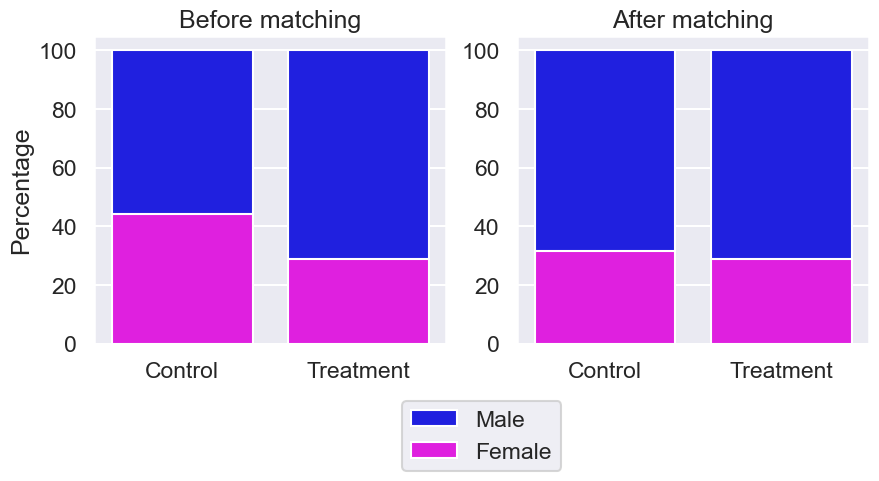

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# Visualise original distribution
sns.barplot(data=gender, x=gender.index.astype(str), y="All", 
            color=M_COLOUR, label=M_LABEL, ax=ax[0])
sns.barplot(data=gender, x=gender.index.astype(str), y='Female', 
            color=F_COLOUR, label=F_LABEL, ax=ax[0])
ax[0].legend(loc='center', bbox_to_anchor=(1.1, -0.3))
ax[0].set_xlabel('')
ax[0].set_ylabel('Percentage')
ax[0].set_title('Before matching')
# Visualise new distribution
gender_after = 100 * pd.crosstab(
    matched_df[TREATMENT].replace({True: T_LABEL, False: C_LABEL}), 
    matched_df['is_female'].replace({True: 'Female', False: 'Male'}), 
    normalize='index'
)
gender_after['All'] = 100
sns.barplot(data=gender_after, x=gender_after.index.astype(str), 
            y="All", color=M_COLOUR, label=M_LABEL, ax=ax[1])
sns.barplot(data=gender_after, x=gender_after.index.astype(str), 
            y='Female', color=F_COLOUR, label=F_LABEL, ax=ax[1])
ax[1].set_xlabel('')
ax[1].set_title('After matching')
ax[1].set_ylabel('');

In [20]:
## 正式评估treatment对效果的影响
summary = matched_df.groupby(TREATMENT)[OUTCOME]\
                    .aggregate(['mean', 'std', 'count'])
summary

,mean,std,count
is_pclass3,,,
False,0.46,0.50,355
True,0.24,0.43,355


In [21]:
c_outcome = summary.loc[False, 'mean']
t_outcome =  summary.loc[True, 'mean']
att = t_outcome - c_outcome
print('The Average Treatment Effect on Treated (ATT): {:.4f}'\
      .format(att))

The Average Treatment Effect on Treated (ATT): -0.2169


In [22]:
y = df[OUTCOME].values
t = df[TREATMENT].values
X = df[['is_female', 'age']]
X = pd.DataFrame(StandardScaler().fit_transform(X), 
                 columns=X.columns).values
model = CausalModel(y, t, X)
model.est_via_matching()
print(model.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.259      0.046     -5.623      0.000     -0.350     -0.169
           ATC     -0.292      0.056     -5.240      0.000     -0.401     -0.183
           ATT     -0.227      0.052     -4.400      0.000     -0.328     -0.126



## CausalML

In [28]:
df2=df[['survived','is_pclass3','is_female','age']]
df2.head()

,survived,is_pclass3,is_female,age
385,1,True,True,63.00
221,1,False,True,63.00
498,1,False,False,80.00
662,1,False,True,62.00
293,1,False,True,60.00


In [29]:
#倾向得分估计
y = df2['survived'].values
X = df[['is_female', 'age']]

from causalml.propensity import ElasticNetPropensityModel
pm = ElasticNetPropensityModel(n_fold=5, random_state=42)
ps = pm.fit_predict(X, y)
pd.DataFrame(ps).head()

/opt/anaconda3/envs/causalml-tf-py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/causalml-tf-py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/causalml-tf-py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/causalml-tf-py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/causalml-tf-py37/lib/python3.7/site-pack

/opt/anaconda3/envs/causalml-tf-py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/causalml-tf-py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/causalml-tf-py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/causalml-tf-py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/causalml-tf-py37/lib/python3.7/site-pack

,0
0,0.63
1,0.63
2,0.14
3,0.64
4,0.64


In [32]:
df_score = df2
df_score['score'] = pd.DataFrame(ps)
df_score.head()

/opt/anaconda3/envs/causalml-tf-py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,survived,is_pclass3,is_female,age,score
385,1,True,True,63.00,0.23
221,1,False,True,63.00,0.74
498,1,False,False,80.00,0.24
662,1,False,True,62.00,0.27
293,1,False,True,60.00,0.21


In [34]:
#倾向得分匹配
from causalml.match import NearestNeighborMatch, create_table_one
psm = NearestNeighborMatch(replace=False,
ratio=1,
random_state=42)
matched = psm.match_by_group(data=df,
treatment_col='is_pclass3',
score_cols=ps,
groupby_col='is_pclass3')
create_table_one(data=matched,
treatment_col='is_pclass3',
features=['is_female','age'])

AssertionError: score_cols must be a list